In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# Read the dataframe
df = pd.read_csv("dataframe.csv")

# Drop any rows with missing values
df = df.dropna()

# Split the data into input features (X) and target variable (y)
X = df.drop("y", axis=1).values
y = df["y"].values

In [2]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

#oversampler = RandomOverSampler(random_state=42)
#X_res, y_res = oversampler.fit_resample(X,y)

In [3]:
# Determine the number of unique critical error types
num_classes = len(np.unique(y))
print(num_classes)

# Encode the target variable using LabelEncoder and one-hot encoding
label_encoder = LabelEncoder()
y_res = label_encoder.fit_transform(y_res)
y_res = to_categorical(y_res)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

12


In [4]:
# Assuming X_train and X_test are your input data arrays
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Assuming y_train and y_test are your label arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Add, GlobalAveragePooling1D, Dense

def residual_block(input_tensor, filters, kernel_size, strides=1):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Downsample the input tensor if strides=2
    if strides == 2:
        input_tensor = Conv1D(filters, 1, strides=strides, padding='same')(input_tensor)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

# Input layer
inputs = Input(shape=(78, 1))

# Initial convolution
x = Conv1D(64, 7, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual blocks
x = residual_block(x, 64, 3)
x = residual_block(x, 64, 3)
x = residual_block(x, 64, 3)

x = residual_block(x, 128, 3, strides=2)
x = residual_block(x, 128, 3)
x = residual_block(x, 128, 3)

x = residual_block(x, 256, 3, strides=2)
x = residual_block(x, 256, 3)
x = residual_block(x, 256, 3)

# Global average pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(12, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 78, 64)       512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 78, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 78, 64)       0           ['batch_normalization[0][0]']

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 39, 128)     512         ['conv1d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 39, 128)      0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv1d_11 (Conv1D)             (None, 39, 128)      49280       ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 39, 128)     512         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 20, 256)      0           ['add_8[0][0]']                  
                                                                                                  
 global_average_pooling1d (Glob  (None, 256)         0           ['activation_18[0][0]']          
 alAveragePooling1D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 12)           3084        ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
Total params: 1,484,044
Trainable params: 1,478,540
Non-trainable params: 5,504
_____________________________

In [6]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
397/397 [==============================] - 54s 115ms/step - loss: 1.2877 - accuracy: 0.5718 - val_loss: 6.5453 - val_accuracy: 0.3582
Epoch 2/50
397/397 [==============================] - 47s 118ms/step - loss: 0.7973 - accuracy: 0.7432 - val_loss: 5.9030 - val_accuracy: 0.4916
Epoch 3/50
397/397 [==============================] - 47s 118ms/step - loss: 0.6653 - accuracy: 0.7801 - val_loss: 3.2652 - val_accuracy: 0.5197
Epoch 4/50
397/397 [==============================] - 47s 118ms/step - loss: 0.6272 - accuracy: 0.7924 - val_loss: 0.7005 - val_accuracy: 0.7824
Epoch 5/50
397/397 [==============================] - 47s 118ms/step - loss: 0.5850 - accuracy: 0.8056 - val_loss: 4.4870 - val_accuracy: 0.5487
Epoch 6/50
397/397 [==============================] - 47s 119ms/step - loss: 0.5536 - accuracy: 0.8122 - val_loss: 0.6710 - val_accuracy: 0.7849
Epoch 7/50
397/397 [==============================] - 48s 121ms/step - loss: 0.5193 - accuracy: 0.8259 - val_loss: 7.1822 - val_ac

In [7]:
import numpy as np
y_pred = model.predict(X_test)

y_pred_classes = []
y_real_classes = []

for item in y_pred:
    y_pred_classes.append(np.argmax(item))

for item in y_test:
    y_real_classes.append(np.argmax(item))
    
print(y_pred_classes[0])
print(y_real_classes[0])
# Assuming your classes are labeled from 0 to 25
predicted_class = np.argmax(y_pred[0])
probability = y_pred[0][predicted_class]

print("Predicted class:", predicted_class)
print("Probability:", probability)

100/100 [==============================] - 3s 25ms/step
2
2
Predicted class: 2
Probability: 0.9996507


In [8]:
import numpy as np
from sklearn.metrics import classification_report

print(classification_report(y_real_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       280
           1       0.87      0.92      0.89       253
           2       0.98      0.92      0.95       290
           3       0.89      0.88      0.89       277
           4       0.83      0.71      0.76       269
           5       0.93      0.50      0.65       247
           6       0.57      0.99      0.72       259
           7       0.87      0.90      0.89       251
           8       0.80      0.82      0.81       251
           9       0.95      0.98      0.96       266
          10       0.78      0.64      0.71       244
          11       0.83      0.80      0.81       284

    accuracy                           0.83      3171
   macro avg       0.85      0.83      0.83      3171
weighted avg       0.85      0.83      0.83      3171



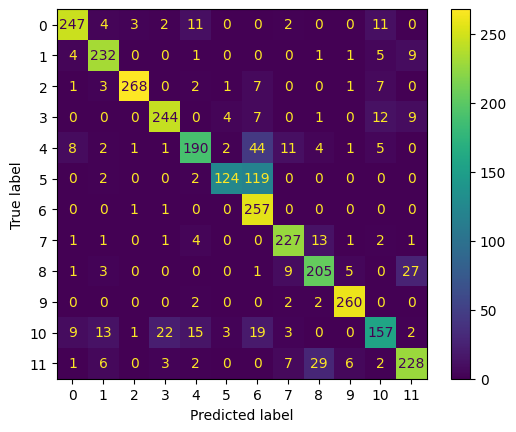

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_real_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()